# Data Loading

In [1]:
#import some necessary librairies

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points

from subprocess import check_output
print(check_output(['ls', '../input/titanic']).decode('utf8')) #check the files available in the directory

gender_submission.csv
test.csv
train.csv



In [2]:
#Now let's import and put the train and test datasets in  pandas dataframe

train = pd.read_csv('../input/titanic/train.csv')
test = pd.read_csv('../input/titanic/test.csv')

In [3]:
#display the first five rows of the train dataset.
train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,S


In [4]:
#display the first five rows of the test dataset.
test.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.500,0,0,330911,7.829,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.000,1,0,363272,7.000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.000,0,0,240276,9.688,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.000,0,0,315154,8.662,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.000,1,1,3101298,12.287,NaN,S


In [5]:
#check the numbers of samples and features
print(f'The train data size before dropping Id feature is : {train.shape}')
print(f'The test data size before dropping Id feature is : {test.shape} ')

#Save the 'Id' column
train_ID = train['PassengerId']
test_ID = test['PassengerId']

#Now drop the 'Id' and 'Ticket' colum since it's unnecessary for  the prediction process.
train.drop('PassengerId', axis = 1, inplace = True)
test.drop('PassengerId', axis = 1, inplace = True)

#check again the data size after dropping the 'Id' variable
print(f'\nThe train data size after dropping Id feature is : {train.shape}')
print(f'The test data size after dropping Id feature is : {test.shape} ')

The train data size before dropping Id feature is : (891, 12)
The test data size before dropping Id feature is : (418, 11) 

The train data size after dropping Id feature is : (891, 11)
The test data size after dropping Id feature is : (418, 10) 


# Data Processing

Let's merge the train and test data for handling missing values and other preprocessing. Also, we retain the number of train and test indices.

In [6]:
ntrain = train.shape[0]
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['Survived'], axis=1, inplace=True)
print(f'all_data size is : {all_data.shape}')

all_data size is : (1309, 10)


## Missing Data

### Finding missing values

Text(0.5, 1.0, 'Percent missing data by feature')

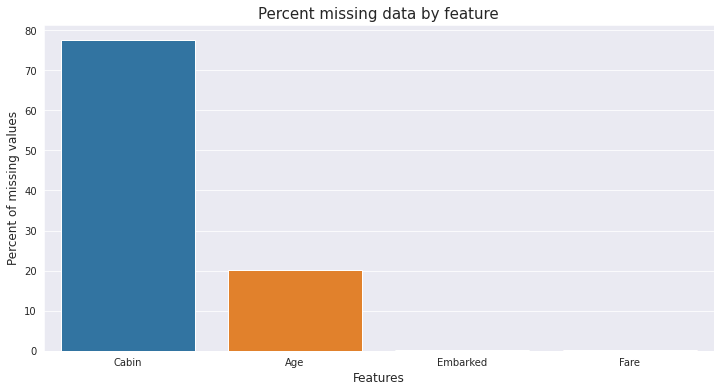

In [7]:
#Find percentage of missing data
missing_data = (all_data.isnull().sum() / len(all_data)) * 100
missing_data = missing_data[missing_data != 0].sort_values(ascending=False)

#Plot the missing data
plt.figure(figsize=(12,6))
sns.barplot(x=missing_data.index, y=missing_data)
plt.xlabel('Features',fontsize=12)
plt.ylabel('Percent of missing values', fontsize=12)
plt.title('Percent missing data by feature', fontsize=15)

### Imputing missing values

In [8]:
# 'Fare' and 'Embarked' have only few missing values. Fill the median for 'Fare' and mode for 'Embarked'.
all_data.fillna({'Fare':train['Fare'].median(), 'Embarked':train['Embarked'].mode()[0]}, inplace = True)

#Since 'Age' is correlated with 'Parch' and 'SibSp', we fill median by grouping the data based on them.
missing_age_index = list(all_data['Age'][all_data["Age"].isnull()].index)
default_age_median = train['Age'].median()
for i in missing_age_index:
    age_median = train['Age'][(train['Parch']==all_data.iloc[i]['Parch']) & (train['SibSp']==all_data.iloc[i]['SibSp'])].median()
    if np.isnan(age_median):
        all_data['Age'].iloc[i] = default_age_median 
    else:
        all_data['Age'].iloc[i] = age_median
    
#Fill Cabin with missing values with 'U' for unknown cabin number and for others take the first letter. 
all_data['Cabin'] = pd.Series(['U' if pd.isnull(i) else i[0] for i in all_data['Cabin']])

Is there any remaining missing value ?

In [9]:
#Check remaining missing values if any 
missing_data = (all_data.isnull().sum() / len(all_data)) * 100
missing_data = missing_data[missing_data != 0].sort_values(ascending=False)
missing_data

Series([], dtype: float64)

No missing value remains

## Categorical Features

We will extract new simplified features from some of these features and encode them accordingly.

### Name

In [10]:
#Extract 'Title' from 'Name'
title = [i.split(",")[1].split(".")[0].strip() for i in all_data["Name"]]
all_data["Title"] = pd.Series(title)
all_data["Title"].value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Ms                2
Mlle              2
Major             2
Sir               1
Mme               1
Dona              1
Jonkheer          1
Lady              1
the Countess      1
Capt              1
Don               1
Name: Title, dtype: int64

In [11]:
#Drop the 'Name' feature
all_data.drop('Name', axis=1, inplace = True)

# Simplify the 'Title' feature
all_data['Title'] =all_data['Title'].replace('Mlle', 'Miss')
all_data['Title'] = all_data['Title'].replace(['Mme','Lady','Ms'], 'Mrs')
all_data['Title'][(all_data['Title'] !=  'Master') & (all_data['Title'] !=  'Mr') & (all_data['Title'] !=  'Miss')  & 
                      (all_data['Title'] !=  'Mrs')] = 'Others'
all_data["Title"].value_counts()

Mr        757
Miss      262
Mrs       201
Master     61
Others     28
Name: Title, dtype: int64

### Sex

In [12]:
all_data['Sex'] = all_data['Sex'].map({'male' : 0, 'female' : 1})

### Ticket

In [13]:
#Extract first character from each ticket
all_data['Ticket'] = all_data['Ticket'].map(lambda x : x[0])
all_data['Ticket'].value_counts()

3    429
2    278
1    210
S     98
P     98
C     77
A     42
W     19
7     13
F     13
4     11
6      9
L      5
5      3
8      2
9      2
Name: Ticket, dtype: int64

In [14]:
# group tickets from A to 8 in one group 4
all_data['Ticket'] = all_data['Ticket'].replace(['A','W','7','F', '4', '6', 'L', '5', '9', '8'],'4')
all_data['Ticket'].value_counts()

3    429
2    278
1    210
4    119
S     98
P     98
C     77
Name: Ticket, dtype: int64

### Cabin

In [15]:
all_data['Cabin'].value_counts()

U    1014
C      94
B      65
D      46
E      41
A      22
F      21
G       5
T       1
Name: Cabin, dtype: int64

In [16]:
#Group  'A', 'F', 'G', 'T' into one group 'A'
all_data['Cabin'] = all_data['Cabin'].replace(['A','F','G','T'], 'A')
all_data['Cabin'].value_counts()

U    1014
C      94
B      65
A      49
D      46
E      41
Name: Cabin, dtype: int64

### Encoding categorical features 

We can safely use one-hot encoding without reducing model performance as we have greatly reduced the number of categories for each feature.

In [17]:
all_data = pd.get_dummies(all_data)

#Check that number of rows is preserved
print(f'all_data size is : {all_data.shape}')

all_data size is : (1309, 27)


# Modelling

In [18]:
#Separate the train and test data
X_train = all_data[:ntrain]
y_train = train['Survived']
X_test = all_data[ntrain:]

#Check whether the datasets have correct size
print(f'train size is : {X_train.shape}')
print(f'target size is: {y_train.shape}')
print(f'test size is : {X_test.shape}')

train size is : (891, 27)
target size is: (891,)
test size is : (418, 27)


We will fit a Random Forest Classifier to this model

Text(0.5, 1.0, 'Variation of accuracy with max_depth')

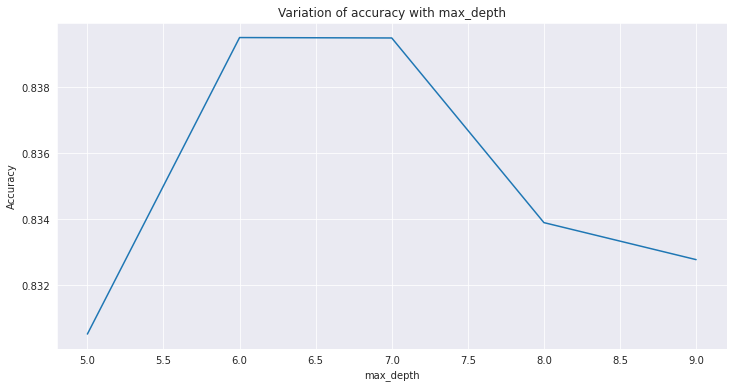

In [19]:
# We tune max_depth to avoid over fitting
max_depth = [x for x in range(5,10)]
cv_score = [cross_val_score(RandomForestClassifier(max_depth = m, n_jobs=-1, random_state = 0), X_train, y_train, 
                                     scoring = 'accuracy', cv=10, n_jobs=-1).mean() for m in max_depth]
cv_score
plt.figure(figsize = (12,6))
sns.lineplot(x=max_depth, y = cv_score)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.title('Variation of accuracy with max_depth')
    

The optimum value of max_depth is 7 and we choose it.

In [20]:
forest = RandomForestClassifier(max_depth = 7, random_state=0, n_jobs=-1)
forest.fit(X_train,y_train)

#Find Accuracy
accuracy = cross_val_score(forest, X_train, y_train, scoring='accuracy', cv=10, n_jobs=-1).mean()
print(f'Accuracy on training set is {round(accuracy,5)}')


Accuracy on training set is 0.8395


Finally, we are ready to fit our model and submit the predictions.

In [21]:
y_test = forest.predict(X_test)
submission = pd.DataFrame({'PassengerId' : test_ID, 'Survived' : y_test})
submission.to_csv('submission.csv', index=False)